In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
import random
from pathlib import Path
from itertools import chain

from munch import Munch

import torch
from torch.utils import data
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder

from collections import namedtuple
from copy import deepcopy
from functools import partial

import cv2
from skimage.filters import gaussian
import torch.nn as nn
import torch.nn.functional as F
import copy
import math

from os.path import join as ospj
import json
import glob
from shutil import copyfile

from tqdm import tqdm
import ffmpeg

import torchvision
import torchvision.utils as vutils
import time
import datetime

In [2]:
root = '/home/jupyter/mnt/datasets/k_hairstyle_full/'
annot = pd.read_pickle('/home/jupyter/mnt/datasets/k_hairstyle/annotation.pkl')
df = annot[(annot.color != 'two-tone') & (annot.color != 'others')]
df = df.sample(frac=1)

paths = df.path.tolist()
colors = df.color.tolist()

unique_colors = set(colors)

color2idx = {
    color: idx
    for idx, color in enumerate(unique_colors)
}

idx2color = {
    idx: color
    for color, idx in color2idx.items()
}

labels = np.array([color2idx[color] for color in colors])
files = np.array([os.path.join(root, path) for path in paths])

In [4]:
unique_colors

{'Ombre',
 'ash brown',
 'black',
 'natural brown',
 'pink-brown',
 'reddish brown',
 'yellowish brown'}

In [18]:
colors = np.array(colors)

In [21]:
colors[colors == 'Ombre']

array(['Ombre', 'Ombre', 'Ombre', ..., 'Ombre', 'Ombre', 'Ombre'],
      dtype='<U15')

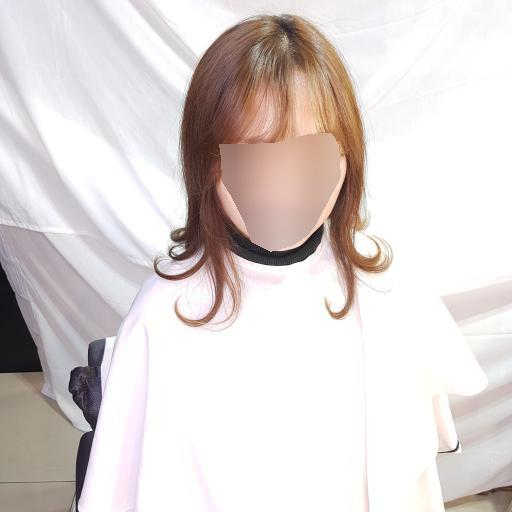

In [38]:
file = np.random.choice(files[colors == 'yellowish brown'].tolist())
image = Image.open(file)
image

In [109]:
rgb = []
for row in annot.itertuples():
    rgb.append(row.rgb)

In [110]:
len(rgb)

500000

In [111]:
rgb = np.array(rgb)

In [112]:
rgb.shape

(500000, 3)

In [53]:
# rgb = rgb / 255. # normalize to [0,1]

In [113]:
rgb.min(), rgb.max()

(5.231818599918639, 246.21929289742985)

In [114]:
from sklearn.cluster import KMeans

In [115]:
kmeans = KMeans(n_clusters=8)

In [116]:
preds = kmeans.fit_predict(rgb)

In [61]:
from sklearn.decomposition import PCA

In [117]:
pca = PCA(n_components=2)

In [118]:
rgb_pca = pca.fit_transform(rgb)

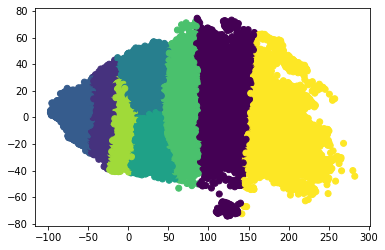

In [119]:
plt.scatter(rgb_pca[:, 0], rgb_pca[:, 1], c=preds);

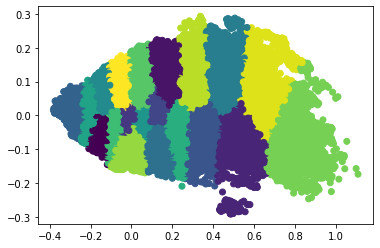

In [69]:
plt.scatter(rgb_pca[:, 0], rgb_pca[:, 1], c=preds);

In [120]:
from collections import Counter

In [121]:
counter = Counter(preds)

In [122]:
counter.most_common(3)

[(1, 123975), (6, 114875), (2, 77877)]

In [123]:
df_cl = annot.copy()
df_cl['label'] = preds

In [126]:
Counter(df_cl[df_cl['label'] == 2].color.values).most_common(3)

[('black', 43886), ('natural brown', 18863), ('reddish brown', 8004)]

In [146]:
Counter(annot.color.values).most_common(9)

[('black', 157791),
 ('natural brown', 111430),
 ('reddish brown', 74363),
 ('yellowish brown', 66994),
 ('others', 49415),
 ('Ombre', 13719),
 ('ash brown', 12213),
 ('two-tone', 10996),
 ('pink-brown', 3079)]

In [137]:
from IPython.display import display

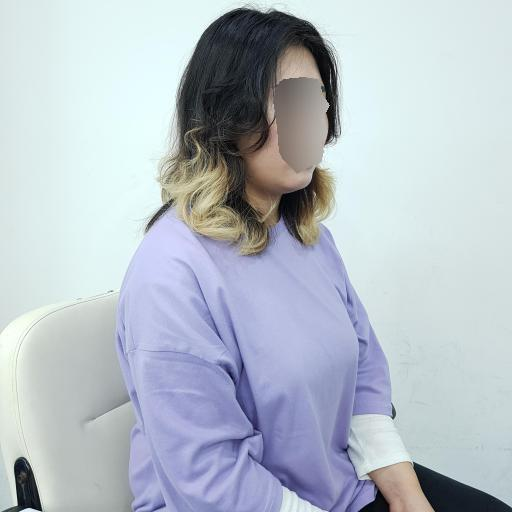

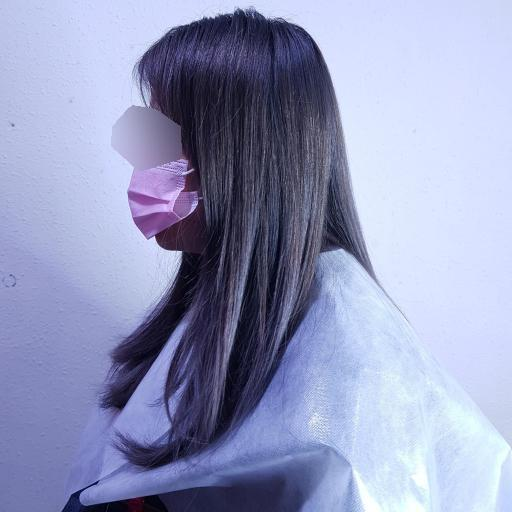

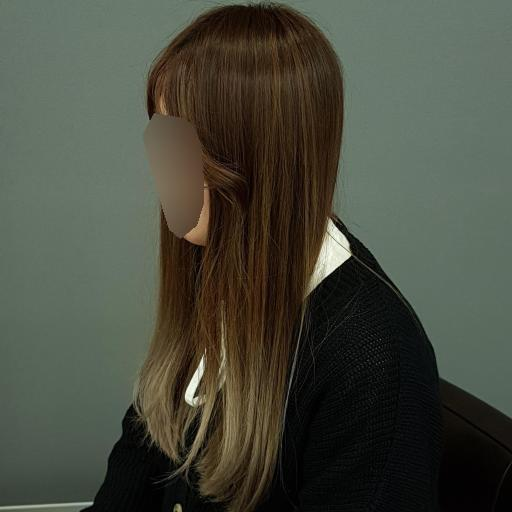

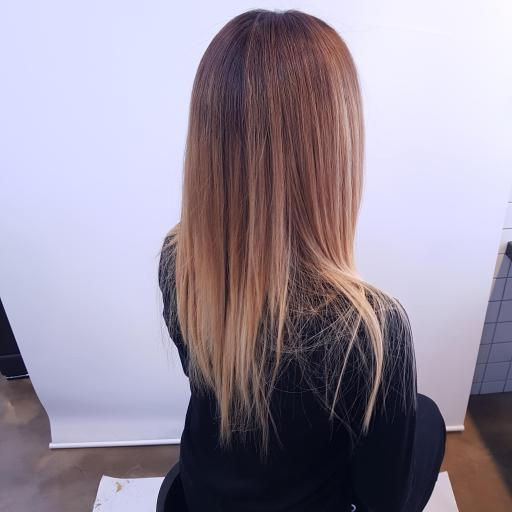

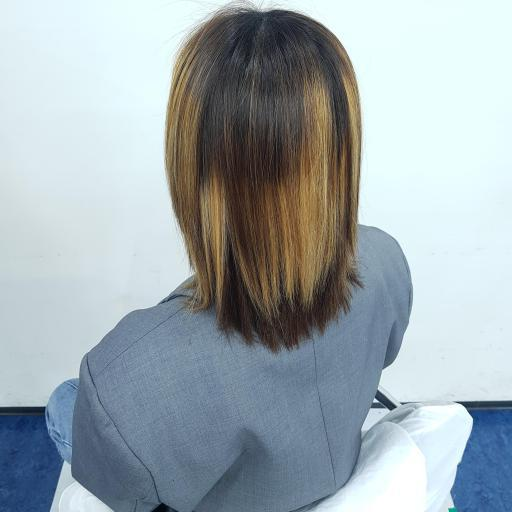

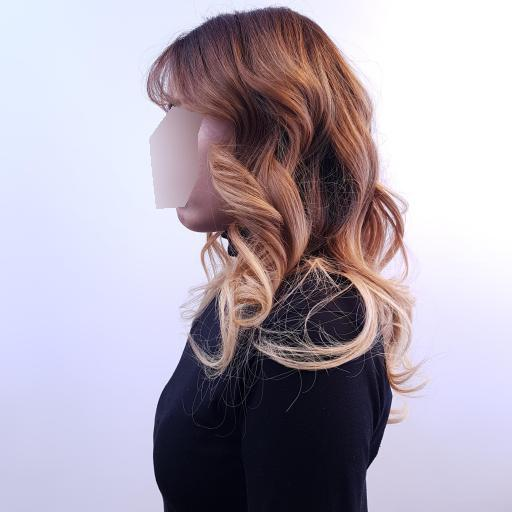

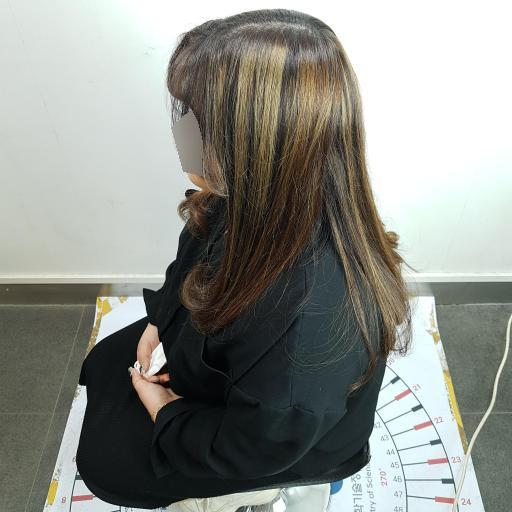

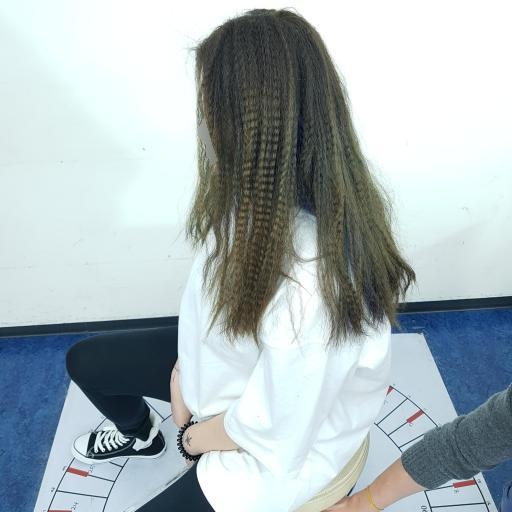

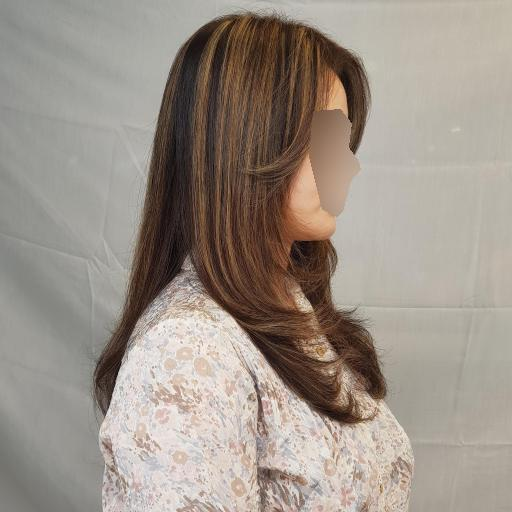

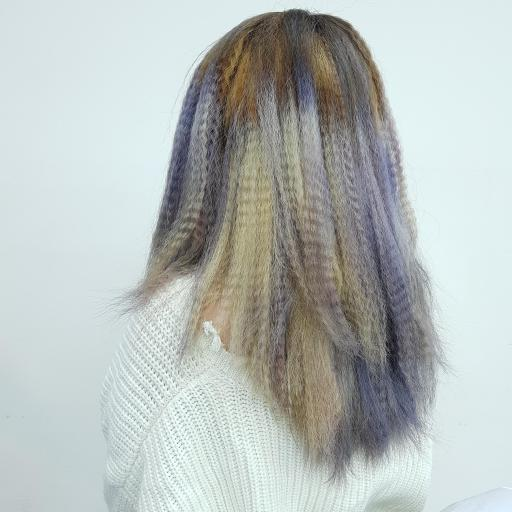

In [159]:
# label = 1
# paths = df_cl[df_cl['label'] == label].path.values
color = 'Ombre'
paths = annot[(annot.color == color) & (annot['before-after'] == 'after')].path.values

for _ in range(10):
    path = np.random.choice(paths)
    filename = os.path.join(root, path)
    display(Image.open(filename))

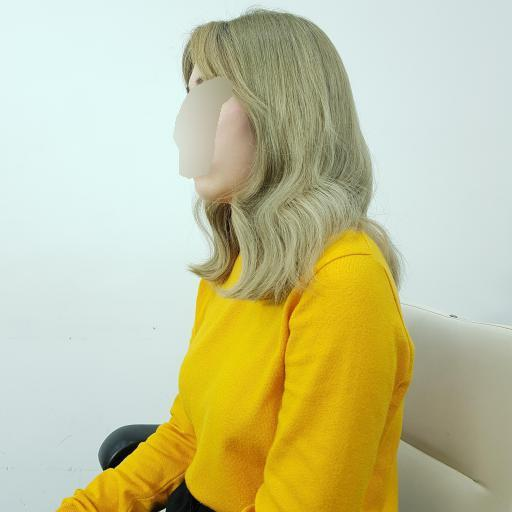

In [161]:
path = np.random.choice(annot.path.values)
filename = os.path.join(root, path)
Image.open(filename)

In [165]:
rgb_all = []
for row in annot.itertuples():
    rgb_all.append(row.rgb)

In [175]:
rgb = np.array(annot[annot.path == path].iloc[0].rgb)

In [176]:
rgb.shape

(3,)

In [177]:
rgb_all = np.array(rgb_all)

In [178]:
rgb_all = rgb_all / 255.
rgb = rgb / 255.

In [181]:
from sklearn.metrics import euclidean_distances

In [183]:
rgb[None, :].shape

(1, 3)

In [185]:
dists = euclidean_distances(rgb[None, :], rgb_all)

In [186]:
dists.shape

(1, 500000)

In [187]:
dists[0].argsort()

array([459960, 459974, 419616, ...,  87199,  57990, 491787])

In [191]:
n = 5_000
blond_idx = dists[0].argsort()[:n]

In [193]:
blond_paths = annot.iloc[blond_idx].path.values

In [211]:
rgb_all = []
for row in annot.itertuples():
    rgb_all.append(row.rgb)
rgb_all = np.array(rgb_all)
rgb = np.array(annot[annot.path == path].iloc[0].rgb)
dists = euclidean_distances(rgb[None, :], rgb_all)
n = 5_000
black_idx = dists[0].argsort()[:n]

In [212]:
black_paths = annot.iloc[black_idx].path.values

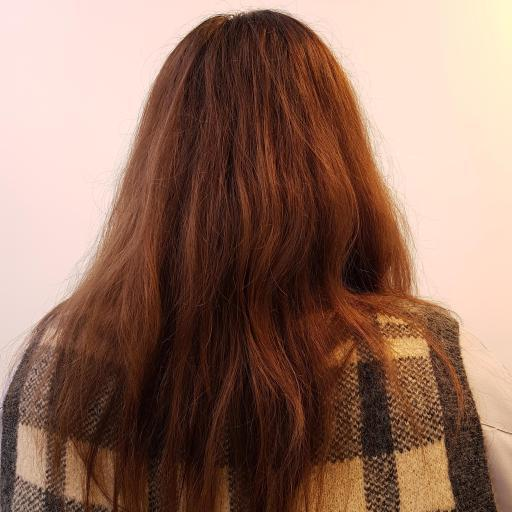

In [293]:
path = np.random.choice(annot.path.values)
filename = os.path.join(root, path)
Image.open(filename)

In [294]:
rgb_all = []
for row in annot.itertuples():
    rgb_all.append(row.rgb)
rgb_all = np.array(rgb_all)
rgb = np.array(annot[annot.path == path].iloc[0].rgb)
dists = euclidean_distances(rgb[None, :], rgb_all)
n = 5_000
brown_idx = dists[0].argsort()[:n]
brown_paths = annot.iloc[brown_idx].path.values

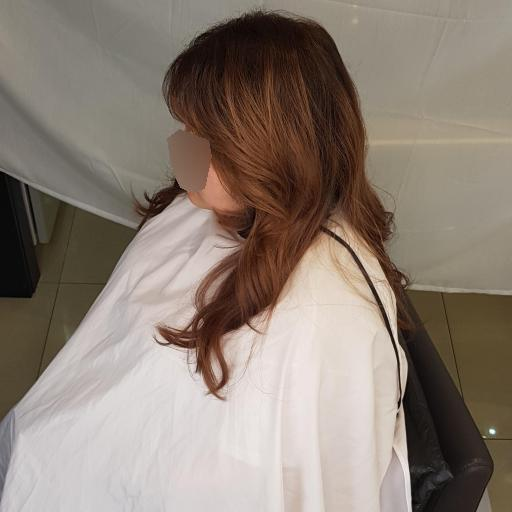

In [307]:
path = np.random.choice(brown_paths)
filename = os.path.join(root, path)
Image.open(filename)

In [311]:
len(set(blond_paths.tolist() + black_paths.tolist() + brown_paths.tolist()))

15000

In [314]:
blond_paths_list = blond_paths.tolist()
black_paths_list = black_paths.tolist()
brown_paths_list = brown_paths.tolist()

In [318]:
df_final = pd.DataFrame()

colors = ['blond'] * 5000 + ['black'] * 5000 + ['brown'] * 5000
labels = [0] * 5000 + [1] * 5000 + [2] * 5000

df_final = df_final.append(annot[annot.path.isin(blond_paths_list)])
df_final = df_final.append(annot[annot.path.isin(black_paths_list)])
df_final = df_final.append(annot[annot.path.isin(brown_paths_list)])

df_final['color'] = colors
df_final['label'] = labels
df_final = df_final[['path', 'color', 'label']]
df_final['path'] = df_final.path.apply(lambda x: os.path.join(root, x))

<ipython-input-318-c4fb1e65b850>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(annot[annot.path.isin(blond_paths_list)])
<ipython-input-318-c4fb1e65b850>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(annot[annot.path.isin(black_paths_list)])
<ipython-input-318-c4fb1e65b850>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(annot[annot.path.isin(brown_paths_list)])


In [321]:
df_final.to_pickle('df_final.pkl')

In [322]:
pd.read_pickle('df_final.pkl')

path  color  label
2917    /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  blond      0
3007    /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  blond      0
3008    /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  blond      0
3127    /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  blond      0
3943    /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  blond      0
...                                                   ...    ...    ...
499812  /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  brown      2
499813  /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  brown      2
499967  /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  brown      2
499970  /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  brown      2
499973  /home/jupyter/mnt/datasets/k_hairstyle_full/pa...  brown      2

[15000 rows x 3 columns]